# Single Variate LSTM Model

To explore the computational performance of our model, I will investigate whether a univariate LSTM model would be appropriate. Essentially, we would model the pollution at future time steps based solely on historical pollution data.

We decided to explore this approach because, based on the correlation and lag data presented in our EDA, we hypothesize that pollution data—specifically from the previous time step—may be the most relevant predictor for our model. As we look into the scalability of our model, the goal is to reduce complexity to decrease computation time without sacrificing too much accuracy. Additionally, if we can eliminate irrelevant noise from the model, it will be highly beneficial.

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import tensorflow as tf
import psutil

In [2]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv')
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)

I will now scale the data and split into training and test data. We have decided on using a 90% split of data, and as it is time series data we will use the first 90% as training and last 10% as test.

In [3]:
df_scaled=df.copy()
scaler = MinMaxScaler()

df_scaled['date'] = pd.to_datetime(df_scaled['date'])

df_scaled.set_index('date', inplace=True)
    
columns = (['pollution'])
    
df_scaled = df_scaled[columns]
df_scaled[columns] = scaler.fit_transform(df_scaled[columns])


df_scaled.head()

,pollution
date,
2010-01-02 00:00:00,0.129779
2010-01-02 01:00:00,0.148893
2010-01-02 02:00:00,0.159960
2010-01-02 03:00:00,0.182093
2010-01-02 04:00:00,0.138833


In [4]:
train_size = int(len(df) * 0.9)  # 90% for training
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (39420, 1)
Test data size: (4380, 1)


## Moving window validation 
In LSTM models, regular cross-validation methods are not appropriate. This is because cross-validation assumes independence between data points, which does not hold for time series data. In time series models, past values are often highly relevant to predicting future values, as the data exhibits temporal dependencies. Additionally, with traditional cross-validation, there is a risk of data leakage. This occurs when the data is randomly split into training and testing sets, potentially allowing future information to influence the training process. This violates the temporal order of the data, where future values should not be used to predict past ones.

Hence we will use moving window validation instead, which ensures data used when making predictions is only from pasa data



In [5]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data.iloc[i:i+sequence_length].values)  # Sequence of pollution values
        labels.append(data.iloc[i + sequence_length])  # Next time step's pollution value (target)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_data, 10)
X_test, y_test = create_sequences(test_data, 10)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (39410, 10, 1), y_train shape: (39410, 1)
X_test shape: (4370, 10, 1), y_test shape: (4370, 1)


In [6]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Basic LSTM model

To start with we will use a large number of epochs of 100, and then look to implement early stopping to improve training time and reduce overfitting. The rest of the hyperparameters chosen are pretty standard when it comes to LSTM models which I will look at adjusting a few later on in relation to improving computation time and GPU performance. For instance batch size will be investigated, which is the number samples of data in a mini batch, which the model does a forward and backward pass on in each epoch. 

Throughout our testing of the models, we will evaluate performance based on both loss (training and validation loss, using mean squared error) and RMSE. Additionally, we will assess GPU performance and training time to draw conclusions about the impact of different modifications to the model.

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


This is due to looking at the hardware requirements for using GPUs on tensorflow on https://www.tensorflow.org/install/pip#windows-native we can see that there is "There is currently no official GPU support for MacOS". As I can not install tensorflow-metal, I will continue to conduct analysis using the version running on CPU, looking at the CPU performance.

Although I will only be looking at CPU training time, Matt who can use a GPU will test GPU performance using my final model.

Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0030 - root_mean_squared_error: 0.0532 - val_loss: 7.3922e-04 - val_root_mean_squared_error: 0.0272
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.1978e-04 - root_mean_squared_error: 0.0303 - val_loss: 5.4696e-04 - val_root_mean_squared_error: 0.0234
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.9204e-04 - root_mean_squared_error: 0.0281 - val_loss: 5.3118e-04 - val_root_mean_squared_error: 0.0230
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.7288e-04 - root_mean_squared_error: 0.0278 - val_loss: 5.1784e-04 - val_root_mean_squared_error: 0.0228
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6657e-04 - root_mean_squared_error: 0.0277 - val_loss: 5.0760e-04 - val_root_mean_squared_error: 0.0225
Epoch 6/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.6288e-04 - root_mean_squared_error: 0.0276 - val_loss: 5.0221e-04 - val_root_mean_squared_error: 0.0224
Ep

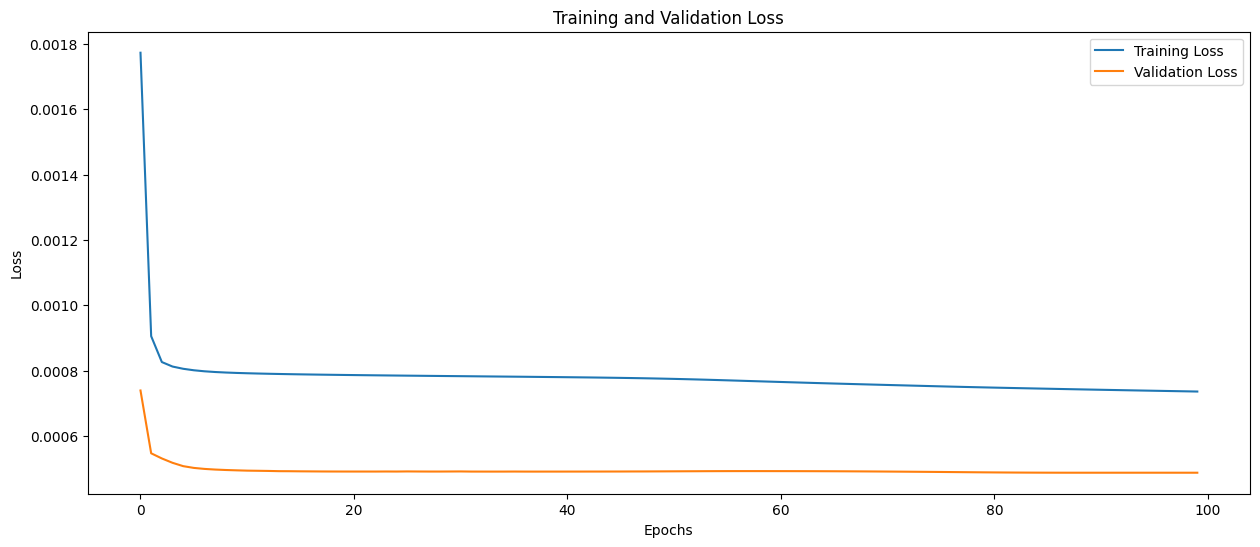

In [8]:
# Set random seed for reproducibility, same seed used in mulitvariate LSTM for comparison
tf.random.set_seed(7)


model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

initial_weights = model.get_weights()

start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=100,                  
    batch_size=64,                
    validation_data=(X_test, y_test)
)

# Output the training time
print("Training Time: ", time.time() - start_time)

# Plot training and validation loss over epochs
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





## Early Stopping

Lets see if we can reduce overfitting and training time.

Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0434 - val_loss: 5.9247e-04 - val_root_mean_squared_error: 0.0243
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.1672e-04 - root_mean_squared_error: 0.0286 - val_loss: 5.1892e-04 - val_root_mean_squared_error: 0.0228
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6902e-04 - root_mean_squared_error: 0.0277 - val_loss: 5.0208e-04 - val_root_mean_squared_error: 0.0224
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6220e-04 - root_mean_squared_error: 0.0276 - val_loss: 4.9832e-04 - val_root_mean_squared_error: 0.0223
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6005e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.9701e-04 - val_root_mean_squared_error: 0.0223
Epoch 6/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.5891e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.9603e-04 - val_root_mean_squared_error: 0.0223
Ep

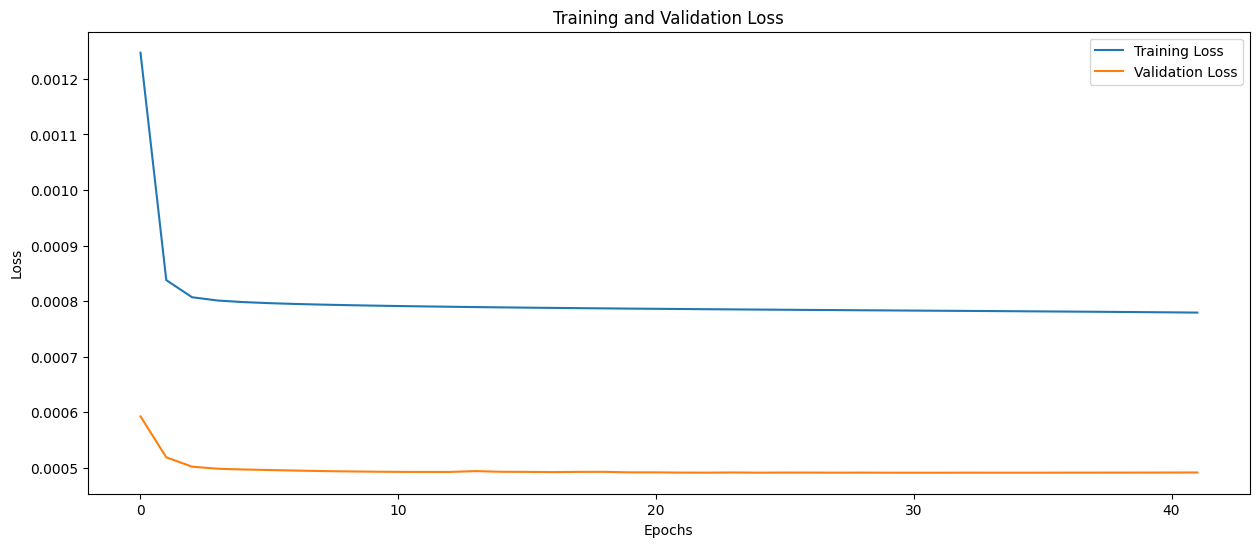

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [9]:
model.set_weights(initial_weights)

early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor (could be 'val_accuracy', 'val_loss', etc.)
    patience=10,                 # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,   # Restore the model with the best weights after training ends
    verbose=1                    # Print messages when early stopping is triggered
)

start_time = time.time() #time taken for model to run
# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=100,                   # Max number of epochs
    batch_size=64,                # Batch size
    validation_data=(X_test, y_test),  # Validation data for early stopping to monitor
     callbacks=[early_stopping]    # Pass the early stopping callback
)
print("Training Time: ", time.time() - start_time)

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.summary()


As we can see, the number of optimal epochs is considered to be roughly to be 20, reducing the training time to 35 seconds when using 17 epochs from 272 seconds.

In [25]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
print(test_results)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
      Train Predictions    Actual
0              0.114229  0.101610
1              0.101308  0.111670
2              0.110676  0.110664
3              0.109885  0.134809
4              0.133338  0.170020
...                 ...       ...
4365           0.012910  0.008048
4366           0.010977  0.010060
4367           0.012891  0.010060
4368           0.012965  0.008048
4369           0.010948  0.012072

[4370 rows x 2 columns]


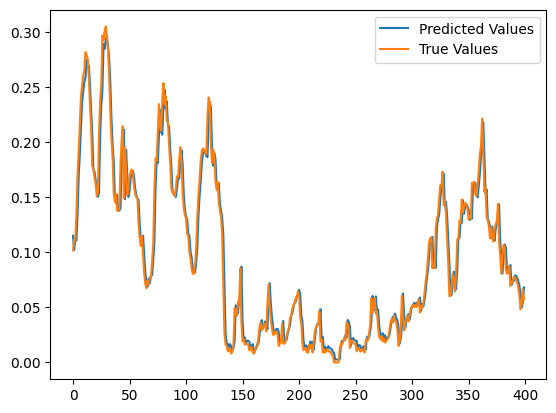

In [11]:
plt.plot(test_results['Train Predictions'][:400], label='Predicted Values')
plt.plot(test_results['Actual'][:400], label='True Values')
plt.legend()
plt.show()

In [26]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.02221


This is just a plot on the standardised values, lets have a look at the inverse and compare results on the actual scale.

   Train Predictions  Actual
0         114.265244   101.0
1         101.463860   111.0
2         111.349236   110.0
3         109.958069   134.0
4         133.789886   169.0


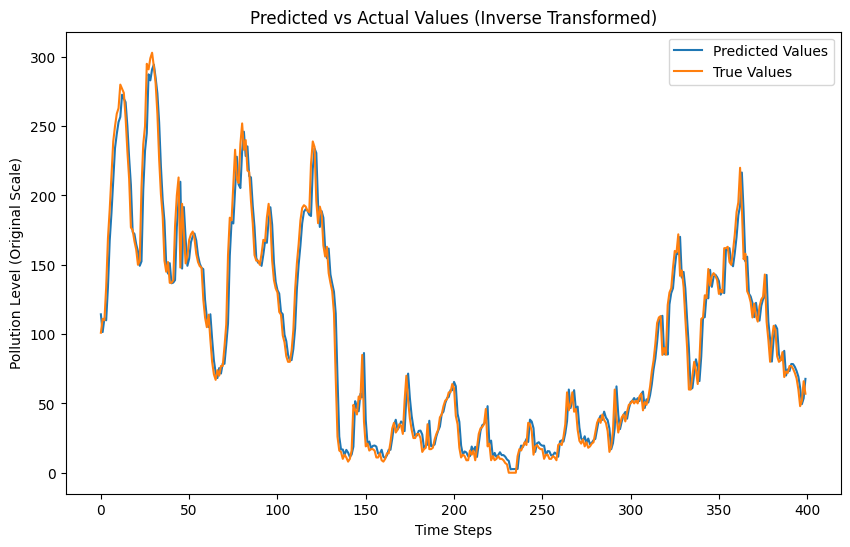

In [12]:
# Assume scaler is the same scaler used to normalize the data
# Reverse the scaling for both predictions and actual values

# Inverse transform for predicted values
test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Inverse transform for actual values (y_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame with actual vs predicted values
test_results = pd.DataFrame(data={'Train Predictions': test_predictions_scaled,
                                  'Actual': y_test_scaled})

# Print the results for a quick check
print(test_results.head())

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(test_results['Train Predictions'][:400], label='Predicted Values')
plt.plot(test_results['Actual'][:400], label='True Values')
plt.legend()
plt.title('Predicted vs Actual Values (Inverse Transformed)')
plt.xlabel('Time Steps')
plt.ylabel('Pollution Level (Original Scale)')
plt.show()


In [22]:
rmse = sqrt(mse(y_test_scaled, test_predictions_scaled))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.074


## Batch size

Taking the number of epochs needed to be roughly 20, we will now test batch size to identify optimal CPU performance agaibst root mean square error.

In [14]:
batch_sizes=[16,32,64,128,256]
results = {"batch_size": [], "rmse":[], "cpu_time": []}

In [15]:
for batch_size in batch_sizes:
        model.set_weights(initial_weights)
        start_time = time.time()
        model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)
        cpu_time = time.time() - start_time
        CPU_scores = model.evaluate(X_test, y_test)
        results["batch_size"].append(batch_size)
        results["rmse"].append(CPU_scores[1])
        results["cpu_time"].append(cpu_time)




Epoch 1/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0386 - val_loss: 5.4234e-04 - val_root_mean_squared_error: 0.0233
Epoch 2/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0315 - val_loss: 5.4201e-04 - val_root_mean_squared_error: 0.0233
Epoch 3/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0314 - val_loss: 5.4454e-04 - val_root_mean_squared_error: 0.0233
Epoch 4/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.9571e-04 - root_mean_squared_error: 0.0312 - val_loss: 5.4620e-04 - val_root_mean_squared_error: 0.0234
Epoch 5/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 9.8617e-04 - root_mean_squared_error: 0.0311 - val_loss: 5.4685e-04 - val_root_mean_squared_error: 0.0234
Epoch 6/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.7872e-04 - root_mean_squared_error: 0.0310 - val_loss: 5.4684e-04 - val_root_mean_squared_error: 0.0234
Epoc

Now we will use these results to compare batch size with training time and rsme 

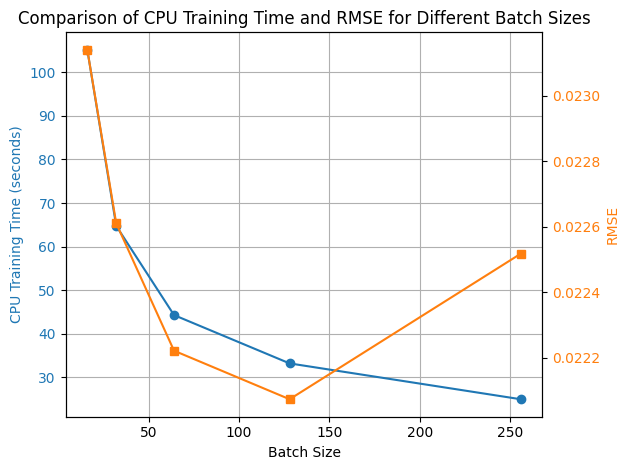

In [16]:
fig, ax1 = plt.subplots()

# Plot CPU training time
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('CPU Training Time (seconds)', color='tab:blue')
ax1.plot(results["batch_size"], results["cpu_time"], color='tab:blue', marker='o', label='CPU Training Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot RMSE
ax2 = ax1.twinx()
ax2.set_ylabel('RMSE', color='tab:orange')
ax2.plot(results["batch_size"], results["rmse"], color='tab:orange', marker='s', label='RMSE')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Show grid and title
plt.title('Comparison of CPU Training Time and RMSE for Different Batch Sizes')
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

As batch size 128 outputted the second best training time and best RMSE so we will use this batch size going forward. Any higher batch size will likely underfit the data set without having too much additional benefit to training time, as we can see with RSME increasing at 256 batch size.

## Dropout layer

We will explore the use of using a dropout layer in our model to prevent overfitting. Based on our current results, the data does not seem to be overfitting as our test rsme has been lower than our training rsme so far, and the compelxity of our model is much lower due to it being univariate. However this process is a common method in LSTM modelling, so I will explore the useful of it. 

A dropout layer is a regularization technique in neural networks, input and recurrent connections to LSTM units are probabilistically excluded from activation forcing the to learn new patterns and generalise better to unseen data.

In [34]:
model.set_weights(initial_weights)
model.add(Dropout(0.2))

start_time = time.time() 
history = model.fit(
    X_train, y_train, 
    epochs=20,                   
    batch_size=128,                
    validation_data=(X_test, y_test))

print("Training Time: ", time.time() - start_time)


Epoch 1/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - root_mean_squared_error: 0.0493 - val_loss: 6.7045e-04 - val_root_mean_squared_error: 0.0259
Epoch 2/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9660e-04 - root_mean_squared_error: 0.0299 - val_loss: 5.5662e-04 - val_root_mean_squared_error: 0.0236
Epoch 3/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.0055e-04 - root_mean_squared_error: 0.0283 - val_loss: 5.1696e-04 - val_root_mean_squared_error: 0.0227
Epoch 4/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.7058e-04 - root_mean_squared_error: 0.0277 - val_loss: 5.0315e-04 - val_root_mean_squared_error: 0.0224
Epoch 5/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6108e-04 - root_mean_squared_error: 0.0276 - val_loss: 4.9829e-04 - val_root_mean_squared_error: 0.0223
Epoch 6/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.5734e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.9620e-04 - val_root_mean_squared_error: 0.0223
Epoch 7/

In [35]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
print(test_results)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
      Train Predictions    Actual
0              0.114242  0.101610
1              0.101324  0.111670
2              0.110699  0.110664
3              0.109894  0.134809
4              0.133352  0.170020
...                 ...       ...
4365           0.012918  0.008048
4366           0.010983  0.010060
4367           0.012899  0.010060
4368           0.012971  0.008048
4369           0.010954  0.012072

[4370 rows x 2 columns]


   Train Predictions  Actual
0         113.556870   101.0
1         100.715660   111.0
2         110.034744   110.0
3         109.234833   134.0
4         132.552170   169.0


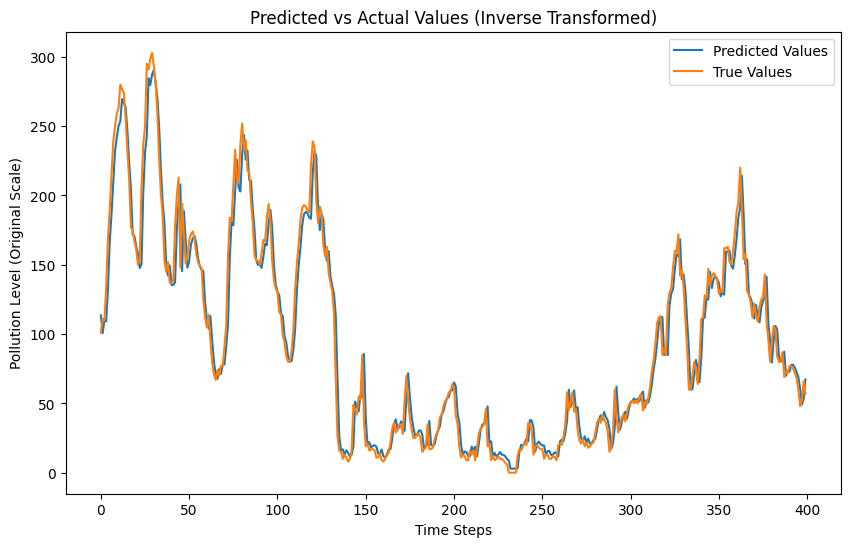

In [36]:
# Assume scaler is the same scaler used to normalize the data
# Reverse the scaling for both predictions and actual values

# Inverse transform for predicted values
test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Inverse transform for actual values (y_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame with actual vs predicted values
test_results = pd.DataFrame(data={'Train Predictions': test_predictions_scaled,
                                  'Actual': y_test_scaled})

# Print the results for a quick check
print(test_results.head())

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(test_results['Train Predictions'][:400], label='Predicted Values')
plt.plot(test_results['Actual'][:400], label='True Values')
plt.legend()
plt.title('Predicted vs Actual Values (Inverse Transformed)')
plt.xlabel('Time Steps')
plt.ylabel('Pollution Level (Original Scale)')
plt.show()


In [37]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.02221


In [39]:
rmse = sqrt(mse(y_test_scaled, test_predictions_scaled))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.074


We have a low test RMSE of 22.074 and training time of 33 seconds.

#talk about generalisation to larger data sets, parraleism etc